# Init libraries

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageNet
from torchvision.transforms import ToTensor,Grayscale,Compose,RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, Resize, functional
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import time as time
import numpy as np
from IPython import display

# Load Dataset and convert to grayscale

In [2]:
# Dataset class for the ImageNet dataset extending the torchvision ImageNet class
class ImageNetDataset(ImageNet):
    # Constructor
    def __init__(self, root, split='train', transform=None):
        # Calling the constructor of the parent class
        super().__init__(root, split=split, transform=transform)
        

    # Getting the image and label at a given index
    def __getitem__(self, index):
        return super().__getitem__(index)

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()
    
    

In [3]:
# Custom dataloader class for the ImageNet dataset 
class ImageNetDataLoader(DataLoader):
    # Constructor
    def __init__(self, root, batch_size, shuffle, split, transform=None):
        imgNet = ImageNetDataset(root, split=split, transform=transform)
        # Calling the constructor of the parent class and reduce the number of samples (must be a multiple of batch_size)
        indices = torch.arange(98000)
        imgNet10 = Subset(imgNet, indices)
        super().__init__(imgNet10,batch_size=batch_size, shuffle=True, num_workers=4)

    # Getting the image transformed to tensor and label at a given index
    def __getitem__(self, index):
        # Getting the image and label at the given index
        image, label = self.dataset[index]
        # Transforming the image to tensor
        image = functional.to_tensor(image)
        return image

    # Get the grayscale image transformed to tensor and label at a given index
    def get_grayscale_image(self, index):
        # Getting the image and label at the given index
        image, label = self.dataset[index]
        # Converting the image to grayscale
        image = functional.to_grayscale(image, num_output_channels=1)
        # Transforming the image to tensor
        image = functional.to_tensor(image)
        return image
    

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()

    

In [4]:
# Define transforms
#Train transforms
train_transform = Compose([
    #ToTensor(),
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    Resize((256, 256))
])
#Test transforms
val_transform = Compose([
    Resize((256, 256))
])
# Data loaders
root="./dataset/imagenet/"
batch_size = 32
train_dataset = ImageNetDataLoader(root, batch_size, shuffle=True, split='train', transform=train_transform)
val_dataset = ImageNetDataLoader(root, batch_size, shuffle=False, split='val', transform=val_transform)
print("Train dataset length: ", len(train_dataset))
print("Validation dataset length: ", len(val_dataset))

Train dataset length:  3063
Validation dataset length:  3063


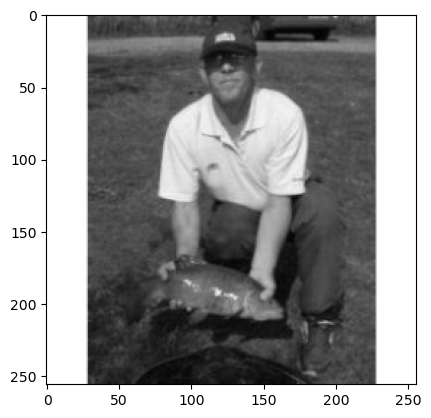

In [5]:
#Show an image from the dataset
image = train_dataset.get_grayscale_image(0)
plt.imshow(image[0], cmap='gray')


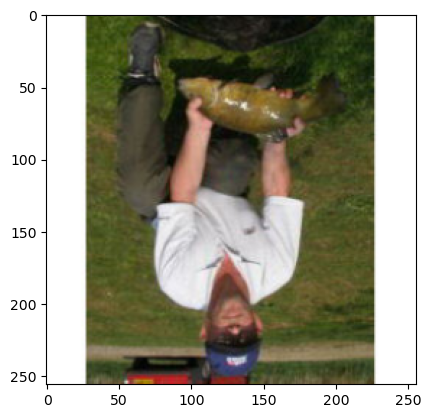

In [6]:
#Plot same image in colors
image = train_dataset.__getitem__(0)
plt.imshow(image.permute(1, 2, 0))

# UNET Autoencoder (Generator)
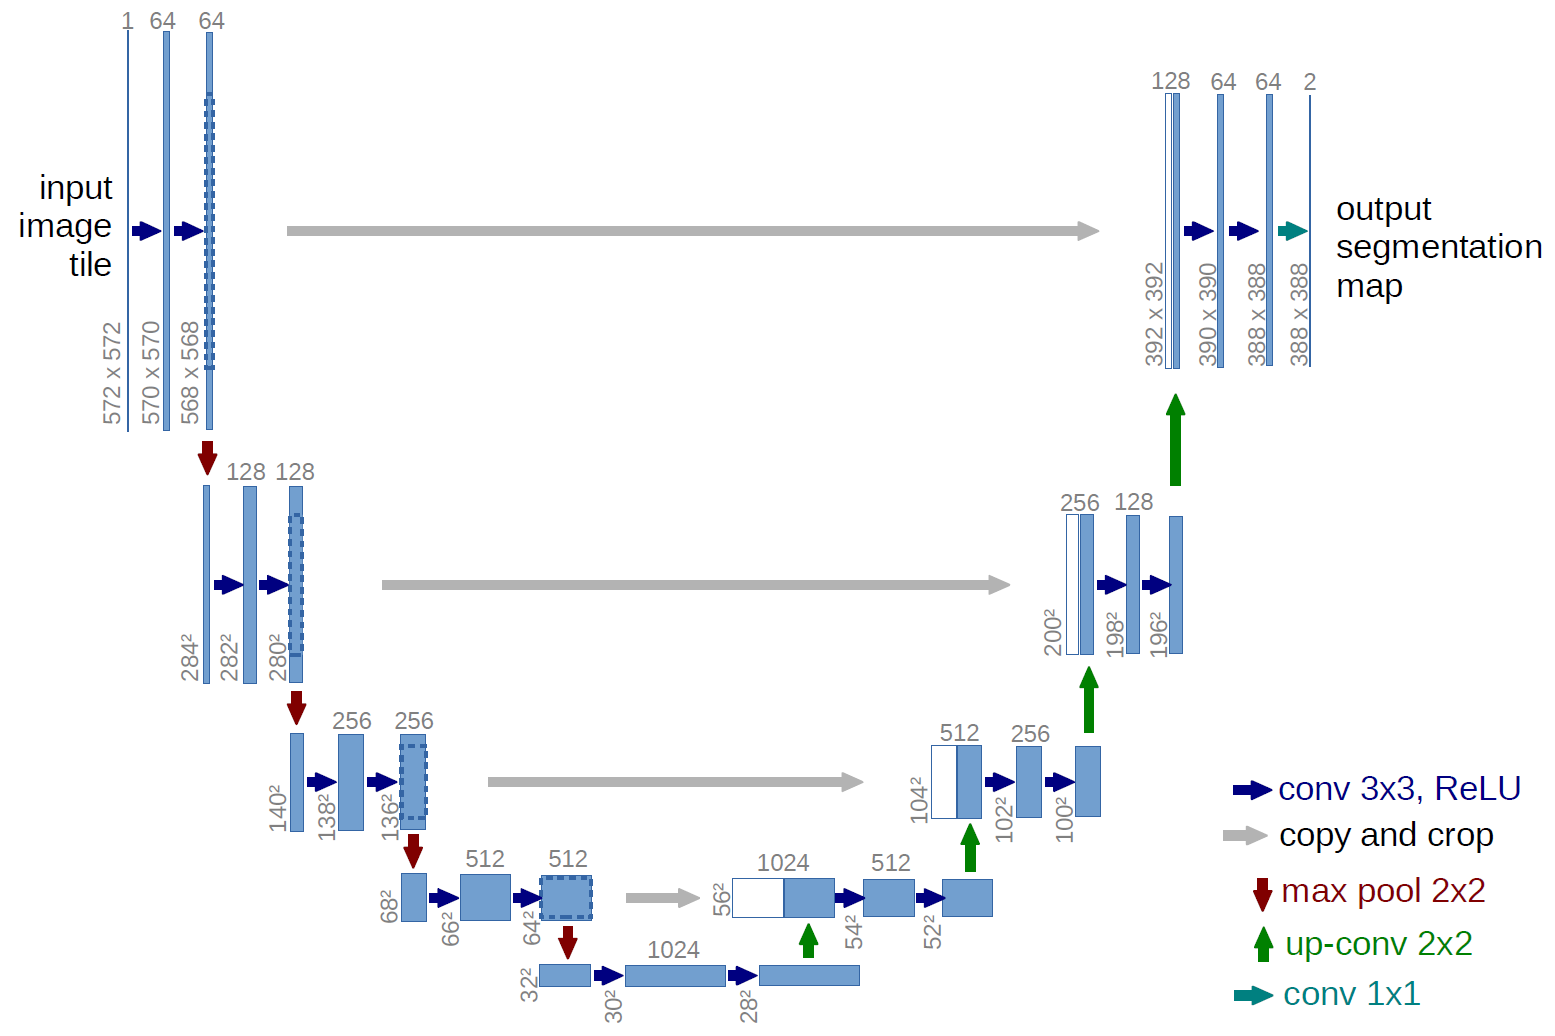

In [7]:
# Implement UNet autoencoder
class UNet(nn.Module):
    ## Constructor of the class 
    # Params:
    # in_channels= input image channels since in our case we are using grayscale images this is 1 for RGB images this would be 3
    # out_channels= outpute image channels since we want to get a colored image this is 3
    # featuress= list of numbers of output features for each block of the net (layer before max pooling) 
    # By default features are initialized like in the paper while in and out channel are already initialized how we want (can still be changed calling the constructor with different params) #
    def __init__(self, in_channels=1, out_channels=3,features=[64, 128, 256, 512]):
        super(UNet,self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder part of the network
        ## Iterate over the features list and create a double convolution block for each feature
        # after each iteration in_channels = feature since the next block in_channel is equals to the previous block output features
        # the bottom layer of the network is added later on#
        for feature in features:
            self.encoder_blocks.append(self.double_convolution(in_channels, feature))
            in_channels = feature
            # Maxpool not applied here because we need to save the output of the encoder block for the skip connection in the decoder part of the network
            
            
        # Decoder part of the network 
        # Iterate through the feature backwards (from the bottom to top of the image) #
        for feature in reversed(features):
            # Upconv part of the decoder block
            self.decoder_blocks.append(
                ## feature * 2 because the decoder block has 2 inputs 
                # (the output of the encoder block with skip connection and the output of the maxpooling of the previous decoder block)
                # kernel_size=2 and stride=2 upsample the image doubling width and height #
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
                )
            # Double convolution part of the decoder block 
            self.decoder_blocks.append(self.double_convolution(feature*2, feature))
        # Bottom layer of encoder/decoder part of the network
        # this layer is the last encoder block and first decoder block and as before uses doube convolution #
        self.bottom_layer = self.double_convolution(features[-1], features[-1]*2)
        # Final convolution layer of decoder part of the network 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    # Double convolution block utility function since both encoder and decoder have a double convolution for each block#
    def double_convolution(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            # In the 2015 paper there was no batch normalization but it should be ok to add it
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    # Forward function of the network
    # Params:
    # self=self
    # x= input image
    def forward(self, x):
        # Store the skip connections for the decoder part of the network
        skip_connections = []
        # Encoder part of the network
        # Iterate over the encoder blocks and apply them to the input image
        # add x to the skip_connections list and then apply maxpool to x
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.maxpool(x)
        
        ## Bottom layer of the network
        # Apply the bottom layer to the output of the last encoder block #
        x = self.bottom_layer(x)
        # Decoder part of the network
        # Reverse the skip connections list to iterate from the bottom layer to the top one (List have been created from top to bottom)
        skip_connections = skip_connections[::-1]
        # Iterate over the decoder blocks and apply them to the input image
        # The starting index is 0 and the step is 2 because the decoder blocks list has 2 blocks for each layer (upconv and double convolution)
        for i in range(0, len(self.decoder_blocks), 2):
            # Get the skip connection for the current layer
            skip_connection = skip_connections[i//2]
            # Apply the upconv block to the input image
            x = self.decoder_blocks[i](x)

            ## Check if the output of the upconv block and the skip connection have the same size
            # If not crop the skip connection to the size of the output of the upconv block
            # In our use case should not be necessary since we resized images to 256x256 in the dataloader #
            if x.shape != skip_connection.shape:
                skip_connection = functional.interpolate(skip_connection, size=x.shape[2:])

            # Concatenate the output of the upconv block and the skip connection
            x = torch.cat((skip_connection, x), dim=1)
            # Apply the double convolution block to the concatenated image
            x = self.decoder_blocks[i+1](x)
        
        # Final convolution layer of the network
        return self.final_conv(x)




## Quick test to see if the unet model returns an image with the same shape than the original one

In [8]:

image = train_dataset.get_grayscale_image(0)
x = image.unsqueeze(0)
model = UNet()  
preds = model(x)
print(x.shape)
print(preds.shape)
## expected output:
# torch.Size([1, 1, 256, 256])
# torch.Size([1, 3, 256, 256]) 
# Output shape has 3 out channels since we want to go from grayscale to RGB #




torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])


# Discriminator

In [9]:
## Define the discriminator network (PatchGAN) 
# params:
# in_channels= channels of the input image + in channels of the unet output image (3 of input image + 3 of unet output image= 6)
# features: Number of out features for each conv block (as in UNet implementation) #
class Discriminator(nn.Module):
    def __init__(self, in_channels=6, features=[64, 128, 256, 512]):
        super().__init__()
        # Define the initial convolution block of the discriminator 
        self.initial= nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        # Define the rest of the convolution blocks of the discriminator
        self.layers = nn.ModuleList()
        in_channels = features[0]
        ## Iterate over the features list and apply a conv block to each element
        # The starting index is 1 because the first element of the features list is already used in the initial block
        # Stride is 2 for all the conv blocks except the last one #
        for i in range(1, len(features)):
            # Apply a conv block to the input image
            stride=1 if features[i] == features[-1] else 2
            self.layers.append(self.conv_block(features[i-1], features[i], stride))
            in_channels = features[i]
        # Add the final convolution block to the discriminator
        self.layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))

    # Define the convolution blocks of the discriminator
    def conv_block(self, in_channels, out_channels, stride=2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding_mode="reflect", bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    ## Define the forward function of the discriminator
    # params:
    # input_image= input image
    # unet_out_image= unet output image #
    def forward(self, input_image, unet_out_image):
        # Concatenate the input image and the unet output image
        x = torch.cat([input_image, unet_out_image], dim=1)
        # Apply the initial convolution block to the concatenated image
        x = self.initial(x)
        # Apply the rest of the convolution blocks to the output of the initial block
        for layer in self.layers:
            x = layer(x)
        
        return x


## Quick test to see if discriminator works

In [10]:
# Test the discriminator network
original_image = train_dataset.__getitem__(0)
grayscale_image = train_dataset.get_grayscale_image(0)
unet = UNet()
y = unet(grayscale_image.unsqueeze(0))
disc = Discriminator()
preds = disc(original_image.unsqueeze(0), y)
print(preds.shape)


torch.Size([1, 1, 26, 26])


## Training function

In [17]:
## Implement save_checkpoint function
# params:
# model= model to save
# optimizer= optimizer to save
# filename= name of the file to save the model
def save_checkpoint(model, optimizer, filename):
    state_dict = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(state_dict, filename)

## Implement load_checkpoint function
# params:
# model= model to load
# optimizer= optimizer to load
# filename= name of the file to load the model
# lr= learning rate to use for the optimizer
def load_checkpoint(model, optimizer, filename, lr):
    state_dict = torch.load(filename)
    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


## Implement WGan training loop
# params:
# epochs= number of epochs
# loader= dataloader
# gen= generator network
# disc= discriminator network
# opt_gen= optimizer for the generator network
# opt_disc= optimizer for the discriminator network
# l1= l1 loss function
# mse= mse loss function
# lambda_l1= lambda value for the l1 loss
# lambda_mse= lambda value for the mse loss
# device= device to use for training
# lambda_gp= lambda value for the gradient penalty
# n_critic= number of critic iterations
# clip_value= value to clip the discriminator weights
# lambda_gp= lambda value for the gradient penalty

def train(epochs, loader, gen, disc, opt_gen, opt_disc, l1, mse, lambda_l1, lambda_mse, device, lambda_gp=10, n_critic=5, clip_value=0.01):
    # Define the tensorboard writer
    writer = SummaryWriter(f"runs/WGAN")
    #Load checkpoints if they exist
    if os.path.exists("generator_checkpoint.pth.tar"):
        load_checkpoint(gen, opt_gen, filename=f"generator_checkpoint.pth.tar",lr=opt_gen.param_groups[0]["lr"])
    if os.path.exists("discriminator_checkpoint.pth.tar"):
        load_checkpoint(disc, opt_disc, filename=f"discriminator_checkpoint.pth.tar",lr=opt_disc.param_groups[0]["lr"])
    # Define the fixed input image to track the training progress
    fixed_input_image = train_dataset.get_grayscale_image(0)
    fixed_input_image = fixed_input_image.unsqueeze(0).to(device)
    # Iterate over the epochs
    for epoch in range(epochs):
        print(f"Epoch [{epoch}/{epochs}]")
        # Iterate over the batches
        batch_idx = 0
        for batch_idx  in range(len(loader)):
            print(f"Batch [{batch_idx}/{len(loader)}]")
            # Set the input image and the target image
            real = train_dataset.__getitem__(batch_idx)
            real = real.to(device)
            grayscale_image = train_dataset.get_grayscale_image(batch_idx)
            input_image = grayscale_image.unsqueeze(0).to(device)
            # Get the output of the unet
            unet.to(device)
            unet_out_image = unet(input_image)
            # Train the discriminator
            disc_loss = train_discriminator(real, unet_out_image, disc, opt_disc, lambda_gp, n_critic, clip_value, device)
            # Train the generator
            gen_loss = train_generator(unet_out_image, real, disc, opt_gen, l1, mse, lambda_l1, lambda_mse)
            # Print the losses
            print(f"Epoch [{epoch}/{epochs}] \t Batch [{batch_idx}/{len(loader)}] \t Generator Loss: {gen_loss.item():.4f} \t Discriminator Loss: {disc_loss.item():.4f}")
            # Log the losses to tensorboard
            writer.add_scalar("Generator Loss", gen_loss.item(), global_step=epoch*len(loader)+batch_idx)
            writer.add_scalar("Discriminator Loss", disc_loss.item(), global_step=epoch*len(loader)+batch_idx)
            # Save the generated image to tensorboard
            with torch.no_grad():
                fake_image = unet(fixed_input_image)
                img_grid = make_grid(fake_image)
                writer.add_image("Generated Image", img_grid)

        # Save the generator and discriminator models
        save_checkpoint(gen, opt_gen, filename=f"generator_checkpoint.pth.tar")
        save_checkpoint(disc, opt_disc, filename=f"discriminator_checkpoint.pth.tar")
        epoch += 1

## Implement train_discriminator function to train Discriminator class
# params:
# real= real image
# unet_out_image= output of the unet
# disc= discriminator network
# opt_disc= optimizer for the discriminator network
# lambda_gp= lambda value for the gradient penalty
# n_critic= number of critic iterations
# clip_value= value to clip the discriminator weights
# device= device to use for training
def train_discriminator(real, unet_out_image, disc, opt_disc, lambda_gp, n_critic, clip_value, device):
    # Iterate over the critic iterations
    for _ in range(n_critic):
        # Zero the gradients
        opt_disc.zero_grad()
        # Reshape the real image
        real = real.view(-1, 3, 256, 256)
        # Get the output of the discriminator
        disc_output = disc(real, unet_out_image).view(-1)
        # Calculate the discriminator loss
        disc_loss = -torch.mean(disc_output)
        # Backpropagate the discriminator loss
        disc_loss.backward(retain_graph=True)
        # Clip the discriminator weights
        for p in disc.parameters():
            p.data.clamp_(-clip_value, clip_value)
        # Get the gradient penalty
        gradient_penalty = get_gradient_penalty(real, unet_out_image, disc, lambda_gp, device)
    return disc_loss

## Implement train_generator function
# params:
# unet_out_image= output of the unet
# real= real image
# disc= discriminator network
# opt_gen= optimizer for the generator network
# l1= l1 loss function
# mse= mse loss function
# lambda_l1= lambda value for the l1 loss
# lambda_mse= lambda value for the mse loss
def train_generator(unet_out_image, real, disc, opt_gen, l1, mse, lambda_l1, lambda_mse):
    # Zero the gradients
    opt_gen.zero_grad()
    # Reshape the real image
    real = real.view(-1, 3, 256, 256)
    # Get the output of the discriminator
    disc_output = disc(real, unet_out_image).view(-1)
    # Calculate the generator loss
    gen_loss = -torch.mean(disc_output)
    # Calculate the l1 loss
    l1_loss = l1(unet_out_image, real)
    # Calculate the mse loss
    mse_loss = mse(unet_out_image, real)
    # Calculate the total generator loss
    total_gen_loss = gen_loss + lambda_l1*l1_loss + lambda_mse*mse_loss
    # Backpropagate the total generator loss
    total_gen_loss.backward()
    return total_gen_loss

## Implement get_gradient_penalty function
# params:
# real= real image
# unet_out_image= output of the unet
# disc= discriminator network
# lambda_gp= lambda value for the gradient penalty
# device= device to use for training
def get_gradient_penalty(real, unet_out_image, disc, lambda_gp, device):
    # Get the batch size
    batch_size = real.shape[0]
    # Get the alpha values
    alpha = torch.rand((batch_size, 1, 1, 1)).to(device)
    # Get the interpolated images
    interpolated_images = (alpha*real + ((1 - alpha)*unet_out_image)).requires_grad_(True)
    # Get the output of the discriminator
    disc_interpolated = disc(interpolated_images, unet_out_image).view(-1)
    # Calculate the gradients
    gradients = torch.autograd.grad(outputs=disc_interpolated, inputs=interpolated_images, grad_outputs=torch.ones_like(disc_interpolated), create_graph=True, retain_graph=True)[0]
    # Calculate the gradient penalty
    gradient_penalty = lambda_gp*torch.mean((gradients.view(batch_size, -1).norm(2, dim=1) - 1)**2)
    return gradient_penalty



## Training of the network

In [18]:
#Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Define the generator network
gen = UNet().to(device)
# Define the discriminator network
disc = Discriminator().to(device)
# Define the optimizers
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.002, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.002, betas=(0.5, 0.999))
# Define the loss functions
l1 = nn.L1Loss()
mse = nn.MSELoss()

cuda


In [ ]:
# Train the model
train(epochs=10, loader=train_dataset, gen=gen, disc=disc, opt_gen=opt_gen, opt_disc=opt_disc, l1=l1, mse=mse, lambda_l1=100, lambda_mse=1, device=device)


Epoch [0/10]
Batch [0/3063]
Epoch [0/10] 	 Batch [0/3063] 	 Generator Loss: 48.6589 	 Discriminator Loss: 0.0062
Batch [1/3063]
Epoch [0/10] 	 Batch [1/3063] 	 Generator Loss: 51.3478 	 Discriminator Loss: 0.0048
Batch [2/3063]
Epoch [0/10] 	 Batch [2/3063] 	 Generator Loss: 40.1953 	 Discriminator Loss: 0.0037
Batch [3/3063]
Epoch [0/10] 	 Batch [3/3063] 	 Generator Loss: 47.0655 	 Discriminator Loss: 0.0048
Batch [4/3063]
Epoch [0/10] 	 Batch [4/3063] 	 Generator Loss: 43.2277 	 Discriminator Loss: 0.0045
Batch [5/3063]
Epoch [0/10] 	 Batch [5/3063] 	 Generator Loss: 50.5238 	 Discriminator Loss: 0.0045
Batch [6/3063]
Epoch [0/10] 	 Batch [6/3063] 	 Generator Loss: 48.9094 	 Discriminator Loss: 0.0045
Batch [7/3063]
Epoch [0/10] 	 Batch [7/3063] 	 Generator Loss: 46.9593 	 Discriminator Loss: 0.0045
Batch [8/3063]
Epoch [0/10] 	 Batch [8/3063] 	 Generator Loss: 41.5792 	 Discriminator Loss: 0.0034
Batch [9/3063]
Epoch [0/10] 	 Batch [9/3063] 	 Generator Loss: 55.3294 	 Discriminator 

Epoch [0/10] 	 Batch [81/3063] 	 Generator Loss: 32.7806 	 Discriminator Loss: 0.0044
Batch [82/3063]
Epoch [0/10] 	 Batch [82/3063] 	 Generator Loss: 39.7789 	 Discriminator Loss: 0.0042
Batch [83/3063]
Epoch [0/10] 	 Batch [83/3063] 	 Generator Loss: 47.2604 	 Discriminator Loss: 0.0041
Batch [84/3063]
Epoch [0/10] 	 Batch [84/3063] 	 Generator Loss: 41.0037 	 Discriminator Loss: 0.0046
Batch [85/3063]
Epoch [0/10] 	 Batch [85/3063] 	 Generator Loss: 46.1007 	 Discriminator Loss: 0.0051
Batch [86/3063]
Epoch [0/10] 	 Batch [86/3063] 	 Generator Loss: 50.0470 	 Discriminator Loss: 0.0048
Batch [87/3063]
Epoch [0/10] 	 Batch [87/3063] 	 Generator Loss: 35.4845 	 Discriminator Loss: 0.0039
Batch [88/3063]
Epoch [0/10] 	 Batch [88/3063] 	 Generator Loss: 29.3786 	 Discriminator Loss: 0.0048
Batch [89/3063]
Epoch [0/10] 	 Batch [89/3063] 	 Generator Loss: 45.3515 	 Discriminator Loss: 0.0042
Batch [90/3063]
Epoch [0/10] 	 Batch [90/3063] 	 Generator Loss: 33.0870 	 Discriminator Loss: 0.0

Epoch [0/10] 	 Batch [161/3063] 	 Generator Loss: 40.1947 	 Discriminator Loss: 0.0048
Batch [162/3063]
Epoch [0/10] 	 Batch [162/3063] 	 Generator Loss: 40.2397 	 Discriminator Loss: 0.0050
Batch [163/3063]
Epoch [0/10] 	 Batch [163/3063] 	 Generator Loss: 38.0224 	 Discriminator Loss: 0.0039
Batch [164/3063]
Epoch [0/10] 	 Batch [164/3063] 	 Generator Loss: 45.6762 	 Discriminator Loss: 0.0045
Batch [165/3063]
Epoch [0/10] 	 Batch [165/3063] 	 Generator Loss: 46.5027 	 Discriminator Loss: 0.0044
Batch [166/3063]
Epoch [0/10] 	 Batch [166/3063] 	 Generator Loss: 36.8449 	 Discriminator Loss: 0.0038
Batch [167/3063]
Epoch [0/10] 	 Batch [167/3063] 	 Generator Loss: 49.3090 	 Discriminator Loss: 0.0041
Batch [168/3063]
Epoch [0/10] 	 Batch [168/3063] 	 Generator Loss: 38.8007 	 Discriminator Loss: 0.0047
Batch [169/3063]
Epoch [0/10] 	 Batch [169/3063] 	 Generator Loss: 37.1989 	 Discriminator Loss: 0.0036
Batch [170/3063]
Epoch [0/10] 	 Batch [170/3063] 	 Generator Loss: 57.0164 	 Disc

Epoch [0/10] 	 Batch [240/3063] 	 Generator Loss: 27.6958 	 Discriminator Loss: 0.0034
Batch [241/3063]
Epoch [0/10] 	 Batch [241/3063] 	 Generator Loss: 52.0375 	 Discriminator Loss: 0.0052
Batch [242/3063]
Epoch [0/10] 	 Batch [242/3063] 	 Generator Loss: 36.7938 	 Discriminator Loss: 0.0026
Batch [243/3063]
Epoch [0/10] 	 Batch [243/3063] 	 Generator Loss: 51.5777 	 Discriminator Loss: 0.0046
Batch [244/3063]
Epoch [0/10] 	 Batch [244/3063] 	 Generator Loss: 41.5007 	 Discriminator Loss: 0.0043
Batch [245/3063]
Epoch [0/10] 	 Batch [245/3063] 	 Generator Loss: 45.2539 	 Discriminator Loss: 0.0049
Batch [246/3063]
Epoch [0/10] 	 Batch [246/3063] 	 Generator Loss: 40.7207 	 Discriminator Loss: 0.0042
Batch [247/3063]
Epoch [0/10] 	 Batch [247/3063] 	 Generator Loss: 39.8397 	 Discriminator Loss: 0.0041
Batch [248/3063]
Epoch [0/10] 	 Batch [248/3063] 	 Generator Loss: 53.2262 	 Discriminator Loss: 0.0046
Batch [249/3063]
Epoch [0/10] 	 Batch [249/3063] 	 Generator Loss: 44.8109 	 Disc

Epoch [0/10] 	 Batch [319/3063] 	 Generator Loss: 42.3233 	 Discriminator Loss: 0.0039
Batch [320/3063]
Epoch [0/10] 	 Batch [320/3063] 	 Generator Loss: 44.5365 	 Discriminator Loss: 0.0050
Batch [321/3063]
Epoch [0/10] 	 Batch [321/3063] 	 Generator Loss: 43.1242 	 Discriminator Loss: 0.0039
Batch [322/3063]
Epoch [0/10] 	 Batch [322/3063] 	 Generator Loss: 64.7562 	 Discriminator Loss: 0.0055
Batch [323/3063]
Epoch [0/10] 	 Batch [323/3063] 	 Generator Loss: 35.9905 	 Discriminator Loss: 0.0041
Batch [324/3063]
Epoch [0/10] 	 Batch [324/3063] 	 Generator Loss: 48.9319 	 Discriminator Loss: 0.0057
Batch [325/3063]
Epoch [0/10] 	 Batch [325/3063] 	 Generator Loss: 37.5291 	 Discriminator Loss: 0.0042
Batch [326/3063]
Epoch [0/10] 	 Batch [326/3063] 	 Generator Loss: 52.0935 	 Discriminator Loss: 0.0043
Batch [327/3063]
Epoch [0/10] 	 Batch [327/3063] 	 Generator Loss: 50.1569 	 Discriminator Loss: 0.0051
Batch [328/3063]
Epoch [0/10] 	 Batch [328/3063] 	 Generator Loss: 44.8024 	 Disc

Epoch [0/10] 	 Batch [398/3063] 	 Generator Loss: 22.7844 	 Discriminator Loss: 0.0029
Batch [399/3063]
Epoch [0/10] 	 Batch [399/3063] 	 Generator Loss: 47.5751 	 Discriminator Loss: 0.0047
Batch [400/3063]
Epoch [0/10] 	 Batch [400/3063] 	 Generator Loss: 29.9277 	 Discriminator Loss: 0.0044
Batch [401/3063]
Epoch [0/10] 	 Batch [401/3063] 	 Generator Loss: 42.9228 	 Discriminator Loss: 0.0040
Batch [402/3063]
Epoch [0/10] 	 Batch [402/3063] 	 Generator Loss: 57.8853 	 Discriminator Loss: 0.0046
Batch [403/3063]
Epoch [0/10] 	 Batch [403/3063] 	 Generator Loss: 41.2178 	 Discriminator Loss: 0.0051
Batch [404/3063]
Epoch [0/10] 	 Batch [404/3063] 	 Generator Loss: 38.3865 	 Discriminator Loss: 0.0042
Batch [405/3063]
Epoch [0/10] 	 Batch [405/3063] 	 Generator Loss: 26.5160 	 Discriminator Loss: 0.0045
Batch [406/3063]
Epoch [0/10] 	 Batch [406/3063] 	 Generator Loss: 37.2639 	 Discriminator Loss: 0.0042
Batch [407/3063]
Epoch [0/10] 	 Batch [407/3063] 	 Generator Loss: 43.2009 	 Disc

Epoch [0/10] 	 Batch [477/3063] 	 Generator Loss: 48.1019 	 Discriminator Loss: 0.0054
Batch [478/3063]
Epoch [0/10] 	 Batch [478/3063] 	 Generator Loss: 46.9812 	 Discriminator Loss: 0.0047
Batch [479/3063]
Epoch [0/10] 	 Batch [479/3063] 	 Generator Loss: 53.3509 	 Discriminator Loss: 0.0040
Batch [480/3063]
Epoch [0/10] 	 Batch [480/3063] 	 Generator Loss: 35.6807 	 Discriminator Loss: 0.0034
Batch [481/3063]
Epoch [0/10] 	 Batch [481/3063] 	 Generator Loss: 38.0958 	 Discriminator Loss: 0.0039
Batch [482/3063]
Epoch [0/10] 	 Batch [482/3063] 	 Generator Loss: 41.3562 	 Discriminator Loss: 0.0036
Batch [483/3063]
Epoch [0/10] 	 Batch [483/3063] 	 Generator Loss: 41.8066 	 Discriminator Loss: 0.0039
Batch [484/3063]
Epoch [0/10] 	 Batch [484/3063] 	 Generator Loss: 42.3198 	 Discriminator Loss: 0.0042
Batch [485/3063]
Epoch [0/10] 	 Batch [485/3063] 	 Generator Loss: 49.2608 	 Discriminator Loss: 0.0042
Batch [486/3063]
Epoch [0/10] 	 Batch [486/3063] 	 Generator Loss: 36.0536 	 Disc

Epoch [0/10] 	 Batch [556/3063] 	 Generator Loss: 31.9345 	 Discriminator Loss: 0.0037
Batch [557/3063]
Epoch [0/10] 	 Batch [557/3063] 	 Generator Loss: 37.5021 	 Discriminator Loss: 0.0039
Batch [558/3063]
Epoch [0/10] 	 Batch [558/3063] 	 Generator Loss: 34.9747 	 Discriminator Loss: 0.0051
Batch [559/3063]
Epoch [0/10] 	 Batch [559/3063] 	 Generator Loss: 34.1385 	 Discriminator Loss: 0.0047
Batch [560/3063]
Epoch [0/10] 	 Batch [560/3063] 	 Generator Loss: 46.4133 	 Discriminator Loss: 0.0042
Batch [561/3063]
Epoch [0/10] 	 Batch [561/3063] 	 Generator Loss: 43.0431 	 Discriminator Loss: 0.0041
Batch [562/3063]
Epoch [0/10] 	 Batch [562/3063] 	 Generator Loss: 41.7095 	 Discriminator Loss: 0.0039
Batch [563/3063]
Epoch [0/10] 	 Batch [563/3063] 	 Generator Loss: 45.4522 	 Discriminator Loss: 0.0040
Batch [564/3063]
Epoch [0/10] 	 Batch [564/3063] 	 Generator Loss: 48.0407 	 Discriminator Loss: 0.0048
Batch [565/3063]
Epoch [0/10] 	 Batch [565/3063] 	 Generator Loss: 40.9012 	 Disc

Epoch [0/10] 	 Batch [635/3063] 	 Generator Loss: 53.1597 	 Discriminator Loss: 0.0045
Batch [636/3063]
Epoch [0/10] 	 Batch [636/3063] 	 Generator Loss: 30.5084 	 Discriminator Loss: 0.0039
Batch [637/3063]
Epoch [0/10] 	 Batch [637/3063] 	 Generator Loss: 34.1398 	 Discriminator Loss: 0.0041
Batch [638/3063]
Epoch [0/10] 	 Batch [638/3063] 	 Generator Loss: 42.7124 	 Discriminator Loss: 0.0044
Batch [639/3063]
Epoch [0/10] 	 Batch [639/3063] 	 Generator Loss: 55.1662 	 Discriminator Loss: 0.0040
Batch [640/3063]
Epoch [0/10] 	 Batch [640/3063] 	 Generator Loss: 49.1008 	 Discriminator Loss: 0.0048
Batch [641/3063]
Epoch [0/10] 	 Batch [641/3063] 	 Generator Loss: 43.8011 	 Discriminator Loss: 0.0048
Batch [642/3063]
Epoch [0/10] 	 Batch [642/3063] 	 Generator Loss: 52.3017 	 Discriminator Loss: 0.0043
Batch [643/3063]
Epoch [0/10] 	 Batch [643/3063] 	 Generator Loss: 59.3482 	 Discriminator Loss: 0.0053
Batch [644/3063]
Epoch [0/10] 	 Batch [644/3063] 	 Generator Loss: 44.1364 	 Disc

Epoch [0/10] 	 Batch [714/3063] 	 Generator Loss: 46.3615 	 Discriminator Loss: 0.0048
Batch [715/3063]
Epoch [0/10] 	 Batch [715/3063] 	 Generator Loss: 45.3728 	 Discriminator Loss: 0.0046
Batch [716/3063]
Epoch [0/10] 	 Batch [716/3063] 	 Generator Loss: 41.8095 	 Discriminator Loss: 0.0050
Batch [717/3063]
Epoch [0/10] 	 Batch [717/3063] 	 Generator Loss: 27.7317 	 Discriminator Loss: 0.0046
Batch [718/3063]
Epoch [0/10] 	 Batch [718/3063] 	 Generator Loss: 46.8153 	 Discriminator Loss: 0.0042
Batch [719/3063]
Epoch [0/10] 	 Batch [719/3063] 	 Generator Loss: 38.1832 	 Discriminator Loss: 0.0036
Batch [720/3063]
Epoch [0/10] 	 Batch [720/3063] 	 Generator Loss: 37.7705 	 Discriminator Loss: 0.0040
Batch [721/3063]
Epoch [0/10] 	 Batch [721/3063] 	 Generator Loss: 59.8568 	 Discriminator Loss: 0.0042
Batch [722/3063]
Epoch [0/10] 	 Batch [722/3063] 	 Generator Loss: 50.4338 	 Discriminator Loss: 0.0055
Batch [723/3063]
Epoch [0/10] 	 Batch [723/3063] 	 Generator Loss: 41.1822 	 Disc

Epoch [0/10] 	 Batch [793/3063] 	 Generator Loss: 51.9369 	 Discriminator Loss: 0.0049
Batch [794/3063]
Epoch [0/10] 	 Batch [794/3063] 	 Generator Loss: 60.3455 	 Discriminator Loss: 0.0049
Batch [795/3063]
Epoch [0/10] 	 Batch [795/3063] 	 Generator Loss: 44.1421 	 Discriminator Loss: 0.0040
Batch [796/3063]
Epoch [0/10] 	 Batch [796/3063] 	 Generator Loss: 37.9906 	 Discriminator Loss: 0.0042
Batch [797/3063]
Epoch [0/10] 	 Batch [797/3063] 	 Generator Loss: 33.1928 	 Discriminator Loss: 0.0044
Batch [798/3063]
Epoch [0/10] 	 Batch [798/3063] 	 Generator Loss: 54.7126 	 Discriminator Loss: 0.0043
Batch [799/3063]
Epoch [0/10] 	 Batch [799/3063] 	 Generator Loss: 41.7392 	 Discriminator Loss: 0.0042
Batch [800/3063]
Epoch [0/10] 	 Batch [800/3063] 	 Generator Loss: 26.9936 	 Discriminator Loss: 0.0040
Batch [801/3063]
Epoch [0/10] 	 Batch [801/3063] 	 Generator Loss: 48.3610 	 Discriminator Loss: 0.0044
Batch [802/3063]
Epoch [0/10] 	 Batch [802/3063] 	 Generator Loss: 30.5943 	 Disc

Epoch [0/10] 	 Batch [872/3063] 	 Generator Loss: 41.9856 	 Discriminator Loss: 0.0038
Batch [873/3063]
Epoch [0/10] 	 Batch [873/3063] 	 Generator Loss: 44.0726 	 Discriminator Loss: 0.0041
Batch [874/3063]
Epoch [0/10] 	 Batch [874/3063] 	 Generator Loss: 49.5961 	 Discriminator Loss: 0.0041
Batch [875/3063]
Epoch [0/10] 	 Batch [875/3063] 	 Generator Loss: 47.2095 	 Discriminator Loss: 0.0030
Batch [876/3063]
Epoch [0/10] 	 Batch [876/3063] 	 Generator Loss: 44.6539 	 Discriminator Loss: 0.0039
Batch [877/3063]
Epoch [0/10] 	 Batch [877/3063] 	 Generator Loss: 38.8405 	 Discriminator Loss: 0.0039
Batch [878/3063]
Epoch [0/10] 	 Batch [878/3063] 	 Generator Loss: 19.5008 	 Discriminator Loss: 0.0030
Batch [879/3063]
Epoch [0/10] 	 Batch [879/3063] 	 Generator Loss: 35.8632 	 Discriminator Loss: 0.0044
Batch [880/3063]
Epoch [0/10] 	 Batch [880/3063] 	 Generator Loss: 33.2421 	 Discriminator Loss: 0.0043
Batch [881/3063]
Epoch [0/10] 	 Batch [881/3063] 	 Generator Loss: 23.7417 	 Disc

Epoch [0/10] 	 Batch [951/3063] 	 Generator Loss: 43.3456 	 Discriminator Loss: 0.0043
Batch [952/3063]
Epoch [0/10] 	 Batch [952/3063] 	 Generator Loss: 42.6671 	 Discriminator Loss: 0.0044
Batch [953/3063]
Epoch [0/10] 	 Batch [953/3063] 	 Generator Loss: 37.8078 	 Discriminator Loss: 0.0040
Batch [954/3063]
Epoch [0/10] 	 Batch [954/3063] 	 Generator Loss: 41.0148 	 Discriminator Loss: 0.0040
Batch [955/3063]
Epoch [0/10] 	 Batch [955/3063] 	 Generator Loss: 41.6185 	 Discriminator Loss: 0.0046
Batch [956/3063]
Epoch [0/10] 	 Batch [956/3063] 	 Generator Loss: 51.2282 	 Discriminator Loss: 0.0042
Batch [957/3063]
Epoch [0/10] 	 Batch [957/3063] 	 Generator Loss: 50.6318 	 Discriminator Loss: 0.0054
Batch [958/3063]
Epoch [0/10] 	 Batch [958/3063] 	 Generator Loss: 53.5018 	 Discriminator Loss: 0.0050
Batch [959/3063]
Epoch [0/10] 	 Batch [959/3063] 	 Generator Loss: 53.4260 	 Discriminator Loss: 0.0040
Batch [960/3063]
Epoch [0/10] 	 Batch [960/3063] 	 Generator Loss: 42.2198 	 Disc

Epoch [0/10] 	 Batch [1030/3063] 	 Generator Loss: 62.6701 	 Discriminator Loss: 0.0052
Batch [1031/3063]
Epoch [0/10] 	 Batch [1031/3063] 	 Generator Loss: 44.6610 	 Discriminator Loss: 0.0041
Batch [1032/3063]
Epoch [0/10] 	 Batch [1032/3063] 	 Generator Loss: 50.6062 	 Discriminator Loss: 0.0040
Batch [1033/3063]
Epoch [0/10] 	 Batch [1033/3063] 	 Generator Loss: 48.6050 	 Discriminator Loss: 0.0043
Batch [1034/3063]
Epoch [0/10] 	 Batch [1034/3063] 	 Generator Loss: 39.6566 	 Discriminator Loss: 0.0041
Batch [1035/3063]
Epoch [0/10] 	 Batch [1035/3063] 	 Generator Loss: 48.8501 	 Discriminator Loss: 0.0045
Batch [1036/3063]
Epoch [0/10] 	 Batch [1036/3063] 	 Generator Loss: 47.1438 	 Discriminator Loss: 0.0041
Batch [1037/3063]
Epoch [0/10] 	 Batch [1037/3063] 	 Generator Loss: 53.3234 	 Discriminator Loss: 0.0048
Batch [1038/3063]
Epoch [0/10] 	 Batch [1038/3063] 	 Generator Loss: 51.4353 	 Discriminator Loss: 0.0040
Batch [1039/3063]
Epoch [0/10] 	 Batch [1039/3063] 	 Generator L

Epoch [0/10] 	 Batch [1108/3063] 	 Generator Loss: 51.5974 	 Discriminator Loss: 0.0045
Batch [1109/3063]
Epoch [0/10] 	 Batch [1109/3063] 	 Generator Loss: 34.8277 	 Discriminator Loss: 0.0043
Batch [1110/3063]
Epoch [0/10] 	 Batch [1110/3063] 	 Generator Loss: 43.0937 	 Discriminator Loss: 0.0041
Batch [1111/3063]
Epoch [0/10] 	 Batch [1111/3063] 	 Generator Loss: 40.5456 	 Discriminator Loss: 0.0040
Batch [1112/3063]
Epoch [0/10] 	 Batch [1112/3063] 	 Generator Loss: 31.9965 	 Discriminator Loss: 0.0045
Batch [1113/3063]
Epoch [0/10] 	 Batch [1113/3063] 	 Generator Loss: 58.1804 	 Discriminator Loss: 0.0038
Batch [1114/3063]
Epoch [0/10] 	 Batch [1114/3063] 	 Generator Loss: 45.1856 	 Discriminator Loss: 0.0045
Batch [1115/3063]
Epoch [0/10] 	 Batch [1115/3063] 	 Generator Loss: 37.7066 	 Discriminator Loss: 0.0045
Batch [1116/3063]
Epoch [0/10] 	 Batch [1116/3063] 	 Generator Loss: 37.6468 	 Discriminator Loss: 0.0046
Batch [1117/3063]
Epoch [0/10] 	 Batch [1117/3063] 	 Generator L

Epoch [0/10] 	 Batch [1186/3063] 	 Generator Loss: 42.3185 	 Discriminator Loss: 0.0044
Batch [1187/3063]
Epoch [0/10] 	 Batch [1187/3063] 	 Generator Loss: 44.2474 	 Discriminator Loss: 0.0049
Batch [1188/3063]
Epoch [0/10] 	 Batch [1188/3063] 	 Generator Loss: 49.1070 	 Discriminator Loss: 0.0038
Batch [1189/3063]
Epoch [0/10] 	 Batch [1189/3063] 	 Generator Loss: 41.7555 	 Discriminator Loss: 0.0041
Batch [1190/3063]
Epoch [0/10] 	 Batch [1190/3063] 	 Generator Loss: 26.2515 	 Discriminator Loss: 0.0036
Batch [1191/3063]
Epoch [0/10] 	 Batch [1191/3063] 	 Generator Loss: 44.1669 	 Discriminator Loss: 0.0043
Batch [1192/3063]
Epoch [0/10] 	 Batch [1192/3063] 	 Generator Loss: 43.0433 	 Discriminator Loss: 0.0043
Batch [1193/3063]
Epoch [0/10] 	 Batch [1193/3063] 	 Generator Loss: 50.0301 	 Discriminator Loss: 0.0042
Batch [1194/3063]
Epoch [0/10] 	 Batch [1194/3063] 	 Generator Loss: 39.0806 	 Discriminator Loss: 0.0040
Batch [1195/3063]
Epoch [0/10] 	 Batch [1195/3063] 	 Generator L

Epoch [0/10] 	 Batch [1264/3063] 	 Generator Loss: 40.2383 	 Discriminator Loss: 0.0044
Batch [1265/3063]
Epoch [0/10] 	 Batch [1265/3063] 	 Generator Loss: 45.6180 	 Discriminator Loss: 0.0045
Batch [1266/3063]
Epoch [0/10] 	 Batch [1266/3063] 	 Generator Loss: 44.5763 	 Discriminator Loss: 0.0048
Batch [1267/3063]
Epoch [0/10] 	 Batch [1267/3063] 	 Generator Loss: 46.3872 	 Discriminator Loss: 0.0046
Batch [1268/3063]
Epoch [0/10] 	 Batch [1268/3063] 	 Generator Loss: 38.4352 	 Discriminator Loss: 0.0045
Batch [1269/3063]
Epoch [0/10] 	 Batch [1269/3063] 	 Generator Loss: 43.7037 	 Discriminator Loss: 0.0046
Batch [1270/3063]
Epoch [0/10] 	 Batch [1270/3063] 	 Generator Loss: 41.2479 	 Discriminator Loss: 0.0038
Batch [1271/3063]
Epoch [0/10] 	 Batch [1271/3063] 	 Generator Loss: 46.3865 	 Discriminator Loss: 0.0046
Batch [1272/3063]
Epoch [0/10] 	 Batch [1272/3063] 	 Generator Loss: 51.4318 	 Discriminator Loss: 0.0045
Batch [1273/3063]
Epoch [0/10] 	 Batch [1273/3063] 	 Generator L